In [1]:
# Author: Thinesh Manisekaran
# Description: MTRN4110 Phase C Assignment 
#              Image processing
# Notes: No Robot image files were used

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img

MAZE_FILE_NAME = "../Maze.png"
MAP_FILE_NAME = "../MapFound.txt"


In [2]:

TL = [0,0]
TR = [1350, 0]
BL = [0, 750]
BR = [1350, 750]

TL_THRESH = [[0,0], [337.5, 375]]
TR_THRESH = [[1012.5,0], [1350, 375]]
BL_THRESH = [[0,375], [337.5, 750]]
BR_THRESH = [[1012.5,375], [1350, 750]]

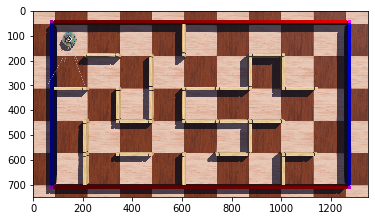

In [3]:
# Task 3.1 - Read and display "Maze.png"

image_src = cv2.imread(MAZE_FILE_NAME) 
image_rgb = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)


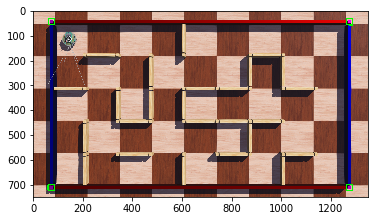

In [4]:
# Task 3.2 - Find corners of maze

image_hsv = cv2.cvtColor(image_src,cv2.COLOR_BGR2HSV)

pixel = [150, 240, 240] # HSV value found by trial and error

upper =  np.array([pixel[0] + 20, pixel[1] + 30, pixel[2] + 60])
lower =  np.array([pixel[0] - 20, pixel[1] - 30, pixel[2] - 110])

image_mask = cv2.inRange(image_hsv,lower,upper)
image_mask = cv2.dilate(image_mask, np.ones((15,15),np.uint8), iterations = 1)

image, contours, hierarchy = cv2.findContours(image_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(image_rgb.copy(), contours, -1, (0,255,0), 3)

plt.imshow(img)


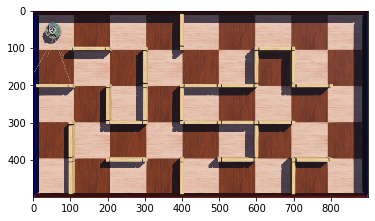

In [5]:
# Task 3.3 - Perspective transform 

centers = []

# get center of corner
for contour in contours:
    x_max = 0
    x_min = 100000
    y_max = 0
    y_min = 100000
    for entry in contour:
        if entry[0][0] > x_max:
            x_max = entry[0][0]
            
        if entry[0][0] < x_min:
            x_min = entry[0][0]
            
        if entry[0][1] > y_max:
            y_max = entry[0][1]
            
        if entry[0][1] < y_min:
            y_min = entry[0][1]        
        
    centers.append([(x_max + x_min)/2, (y_max + y_min)/2])

ordered_centers = [[], [], [], []]
    
# try to approximate edge of corners
for center in centers:
    if center[0] < 337.5 and center[1] < 375:
        ordered_centers[0] = center
    elif center[0] >= 337.5 and center[1] < 375:
        ordered_centers[1] = center
    elif center[0] < 337.5 and center[1] >= 375:
        ordered_centers[2] = center
    else:
        ordered_centers[3] = center
           
src = np.float32(ordered_centers)
dst = np.float32([TL, TR, BL, BR])

matrix = cv2.getPerspectiveTransform(src, dst)
image_warped = cv2.warpPerspective(image_rgb.copy(), matrix, (1350, 750))
image_warped = cv2.resize(image_warped, (900, 500), interpolation = cv2.INTER_AREA)

plt.imshow(image_warped)


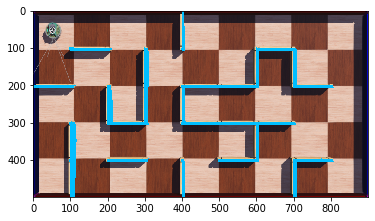

In [6]:
# Task 3.4 - Detect internal walls

image_BGR = cv2.cvtColor(image_warped.copy(), cv2.COLOR_RGB2BGR)
image_hsv = cv2.cvtColor(image_BGR,cv2.COLOR_BGR2HSV)

pixel = [20, 90, 230] # HSV value found by trial and error

upper =  np.array([pixel[0] + 5, pixel[1] + 5, pixel[2] + 20])
lower =  np.array([pixel[0] - 5, pixel[1] - 5, pixel[2] - 20])

image_mask = cv2.inRange(image_hsv,lower,upper)
image_mask = cv2.morphologyEx(image_mask, cv2.MORPH_CLOSE, np.ones((60,60),np.uint8))
image_mask = cv2.morphologyEx(image_mask, cv2.MORPH_OPEN, np.ones((2,2),np.uint8))
image_mask = cv2.dilate(image_mask, np.ones((2,2),np.uint8), iterations = 1)

image, contours, hierarchy = cv2.findContours(image_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.fillPoly(image_warped.copy(), pts = np.array(contours), color = (0, 191, 255))

image_mask_map = image_mask.copy()

plt.imshow(img)



In [7]:
# Task 3.5 - Detect the location and heading of the robot
# PART 1 - Identify center of QR code image on robot

im = img.copy()

im[0:500, 125:775, :] = 0
im[125:375, 0:900, :] = 0

pixel = [120, 3, 230] # HSV value found by trial and error

image_hsv = cv2.cvtColor(im,cv2.COLOR_RGB2HSV)

upper =  np.array([pixel[0] + 10, pixel[1] + 10, pixel[2] + 40])
lower =  np.array([pixel[0] - 10, pixel[1] - 10, pixel[2] - 40])

image_mask = cv2.inRange(image_hsv,lower,upper)
img_use = image_mask.copy() 

image_mask = cv2.morphologyEx(image_mask, cv2.MORPH_CLOSE, np.ones((50,50),np.uint8))
image_mask = cv2.morphologyEx(image_mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))

image, contours, hierarchy = cv2.findContours(image_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

x_sum = 0
y_sum = 0

# go through all contours to find center of QR code looking image on robot
for contour in contours:
    x_max = 0
    x_min = 100000
    y_max = 0
    y_min = 100000
    for entry in contour:
        x_sum += entry[0][0]
        y_sum += entry[0][1]

        if entry[0][0] > x_max:
            x_max = entry[0][0]
            
        if entry[0][0] < x_min:
            x_min = entry[0][0]
            
        if entry[0][1] > y_max:
            y_max = entry[0][1]
            
        if entry[0][1] < y_min:
            y_min = entry[0][1]    
                    
center = [int((x_min + x_max)/2), int((y_min + y_max)/2)]


In [8]:
# Task 3.5 - Detect the location and heading of the robot
# PART 2 - Warp robot image to 500 by 500 image


tl = [center[0]-25, center[1]-25]
tr = [center[0]+25, center[1]-25]
bl = [center[0]-25, center[1]+25]
br = [center[0]+25, center[1]+25]

tl_1 = [0, 0]
tr_1 = [500, 0]
bl_1 = [0, 500]
br_1 = [500, 500]

image_mask[0:(center[1]-25), 0:(center[0]-50)] = 0
image_mask[(center[1]-25):(center[1]+25), (center[0]-25):(center[0]+25)] = 255
image_mask[(center[1]+25):500, (center[0]+25):900] = 0

img_draw = img.copy()

img[:, :, 0] = img[:, :, 0] & image_mask
img[:, :, 1] = img[:, :, 1] & image_mask
img[:, :, 2] = img[:, :, 2] & image_mask

src = np.float32([tl, tr, bl, br])
dst = np.float32([tl_1, tr_1, bl_1, br_1])

matrix = cv2.getPerspectiveTransform(src, dst)
image_warped = cv2.warpPerspective(img.copy(), matrix, (500, 500))
image_warped = cv2.resize(image_warped, (500, 500), interpolation = cv2.INTER_AREA)


In [9]:
# Task 3.5 - Detect the location and heading of the robot
# PART 3 - Find center of largest contour in robot QR code image

pixel = [0, 2, 240] # HSV value found by trial and error

image_hsv = cv2.cvtColor(image_warped,cv2.COLOR_BGR2HSV)

upper =  np.array([pixel[0] + 10, pixel[1] + 10, pixel[2] + 40])
lower =  np.array([pixel[0] - 10, pixel[1] - 10, pixel[2] - 40])

image_mask = cv2.inRange(image_hsv,lower,upper)
image_mask = cv2.morphologyEx(image_mask, cv2.MORPH_OPEN, np.ones((10,10),np.uint8))

image_2, contours_robot, hierarchy_2 = cv2.findContours(image_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
largest_robot_contour = max(contours_robot, key = cv2.contourArea)

x_max = 0
x_min = 100000
y_max = 0
y_min = 100000

for entry in largest_robot_contour:

    x_sum += entry[0][0]
    y_sum += entry[0][1]

    if entry[0][0] > x_max:
        x_max = entry[0][0]

    if entry[0][0] < x_min:
        x_min = entry[0][0]

    if entry[0][1] > y_max:
        y_max = entry[0][1]

    if entry[0][1] < y_min:
        y_min = entry[0][1]    
        
center_largest = [int((x_min + x_max)/2), int((y_min + y_max)/2)]

In [10]:
# Task 3.5 - Detect the location and heading of the robot
# PART 4 - Find starting position and direction based on center of largest contour
#          compared to pixel 250 250 in warped image

left = center[0] < 125
top = center[1] < 125 

startPos = "TL"

if left and top:
    startPos = "TL"
elif left and not top:
    startPos = "BL"
elif not left and top:
    startPos = "TR"
elif not left and not top:
    startPos = "BR"
else:
    print("ERROR Position invalid")

print(startPos)

direction = "N"

if startPos == "TL":
    if center_largest[0] < 230:
        direction = "S"
    else: 
        direction = "E"
elif startPos == "TR":
    if center_largest[0] < 230:
        direction = "S"
    else: 
        direction = "W"
elif startPos == "BL":
    if center_largest[0] > 270:
        direction = "N"
    else: 
        direction = "E"
elif startPos == "BR":
    if center_largest[0] > 270:
        direction = "N"
    else:
        direction = "W"
else:
    print("ERROR Position invalid")

print(direction)

TL
S


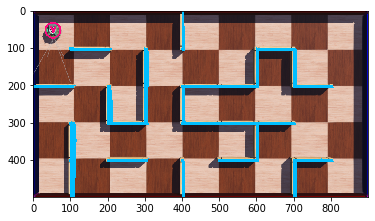

In [11]:
# Task 3.5 - Detect the location and heading of the robot
# PART 5 - Draw outline of robot and direction on image

cv2.circle(img_draw, (center[0], center[1]), 20, (255, 8, 127), 3)

text = "v"
if direction == "N":
    text = "^"
elif direction == "E":
    text = ">"
elif direction == "S":
    text = "v"
else:
    text = "<"
    
font = cv2.FONT_HERSHEY_SIMPLEX 
   
img_draw = cv2.putText(img_draw, text, (center[0]-7, center[1]+5), font, 1, (255, 8, 127), 3, cv2.LINE_AA)

plt.imshow(img_draw)


In [12]:
# Task 3.6 - Write maze layout to file 
# Part 1 -  fill up list for each of the 45 vertices
#           [down wall, right wall] true or false for each vertex

vertex_walls = []

for row in range(5):
    for col in range(9):
        # get rough center pixel values
        centerx = 100*col + 50
        centery = 100*row + 50
        
        rightWall = False
        bottomWall = False
        
        if col != 8 and row != 4:
            # check right wall           
            if np.any(image_mask_map[centery, centerx:centerx+100] == 255):
                rightWall = True
            
            # check bottom wall
            if np.any(image_mask_map[centery:centery+100, centerx] == 255):
                bottomWall = True
                
        elif col == 8 and row != 4:
            # check bottom wall
            if np.any(image_mask_map[centery:centery+100, centerx] == 255):
                bottomWall = True
            
            # right wall is false as it will be drawn in
            
        elif col != 8 and row == 4:
            # check right wall
            if np.any(image_mask_map[centery, centerx:centerx+100] == 255):
                rightWall = True
                        
            # bottom wall is false as it will be drawn in
        
        vertex_walls.append([rightWall, bottomWall])




In [13]:
# Task 3.6 - Write maze layout to file 
# Part 2 - Form map from vertex list 

row_first = " --- --- --- --- --- --- --- --- --- "
row_end   = row_first

horizs = ["|", "|", "|", "|", "|"]
verts = ["", "", "", ""]

for row in range(5):
    for col in range(9):
        index = row*9 + col
        if row == 0 and startPos == "TL" and col == 0:
            if direction == "S":
                horizs[row] += " v "
            else: 
                horizs[row] += " > "
        elif row == 0 and startPos == "TR" and col == 8:
            if direction == "S":
                horizs[row] += " v "
            else: 
                horizs[row] += " < "       
        
        elif row == 4 and startPos == "BL" and col == 0:
            if direction == "N":
                horizs[row] += " ^ "
            else: 
                horizs[row] += " > "      
                
        elif row == 4 and startPos == "BR" and col == 8:
            if direction == "N":
                horizs[row] += " ^ "
            else: 
                horizs[row] += " < "         
                
        else:
            horizs[row] += "   "
        
        if vertex_walls[index][0]:
            horizs[row] += "|"
        else:
            if col != 8:
                horizs[row] += " "
        
    horizs[row] += "|"
    

for row in range(4):
    for col in range(9):
        index = row*9 + col

        if vertex_walls[index][1]:
            verts[row] += " ---"
        else: 
            verts[row] += "    "
    

finalMap = row_first + "\n"

for i in range(4):
    finalMap += horizs[i] + "\n"
    finalMap += verts[i]  + "\n"
    
finalMap += horizs[4] + "\n" + row_end + "\n"

print(finalMap)


 --- --- --- --- --- --- --- --- --- 
| v             |                   |
     ---                 ---        
|           |           |   |       |
 ---             --- ---     ---    
|       |   |   |                   |
         ---     --- --- ---        
|   |                   |           |
         ---         ---     ---    
|   |           |           |       |
 --- --- --- --- --- --- --- --- --- 



In [14]:
# Task 3.6 - Write maze layout to file 
# Part 3 - Write to file

f = open(MAP_FILE_NAME, "w")
f.write(finalMap)
f.close()